## How does modulating the frequency of a laser change it's lineshape? 
By Josiah Sinclair

## Some useful Python packages

In [29]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import scipy as sp
from scipy import signal as sig
from scipy.optimize import curve_fit
mpl.rcParams['text.usetex'] = True

## Define my oscillator

Let's start by just considering an electric field oscillating at 1e9 Hz (I will consider a MASER in this tutorial, but my results will be completely general to optical fields). 

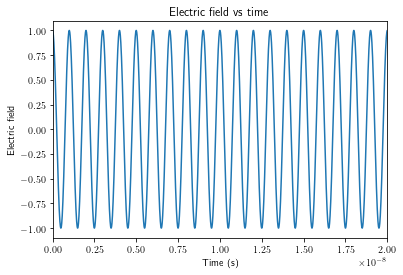

In [30]:
dt = 1e-11
t_max = 10e-5
t = np.arange(0,t_max,dt) #Timing resolution
f_0 = 1e9 # This laser is more of a maser
E = np.cos(2*np.pi*f_0*t)

fig, ax = plt.subplots()
ax.plot(t,E, '-')
ax.set_title("Electric field vs time")
ax.set_ylabel("Electric field")
ax.set_xlabel("Time (s)")
ax.set_xlim(0,20/f_0)
plt.show()


I'm going to imagine that I'm trying to broaden out the frequency of the laser by intentionally adding frequency noise with an AOM. 

To accomplish this, I first need a good source of random (totally uncorrelated) noise. I'll use a function generator which produces a stream of noise that looks like this. 

## Generating random noise

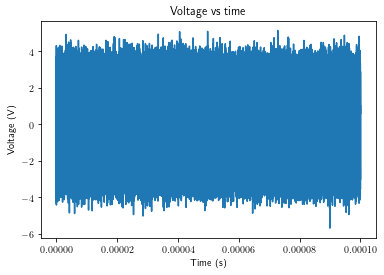

In [3]:
V = np.random.normal(0,1,len(t))

fig, ax = plt.subplots()
ax.plot(t,V, '-')
ax.set_title("Voltage vs time")
ax.set_ylabel("Voltage (V)")
ax.set_xlabel("Time (s)")
plt.show()

Perhaps I don't know what the bandwidth on my function generators white noise output is, so I'm going to lowpass filter the noise myself using a couple of different lowpass filters. When I lowpass filter, I also need to increase the amplitude, so that the amplitude of my noise stays constant for different lowpass filters. Below, I've plotted the spectrum of my noise, and below that, I've plotted a time series of the noise for different lowpass filters. 

In [4]:
# I will use this function
def FrequencyFilter(t,ydata, cutoff_frequency):
    rms_i = np.std(ydata)
    dt = abs(t[2]-t[1])
    df = 1.0/(abs(max(t)-min(t)))
    f_max = 1.0/dt
    f= np.arange(-f_max/2-df/2.0,f_max/2,df)
    FT = np.fft.fftshift(np.fft.fft(ydata)) # Take a Fourier transform.
    Filter_Function = np.exp(-(2*np.pi*f)**2/(2*2*np.pi*cutoff_frequency)**2) # Filter function.
    Filtered_FT = FT*Filter_Function 
    Filtered_E_T = np.real(np.fft.ifft(np.fft.ifftshift(Filtered_FT)))
    rms_f = np.std(Filtered_E_T)
    multiplier = (rms_i/rms_f)
    return((Filtered_E_T - np.mean(Filtered_E_T))*multiplier) # Returns the frequency filtered field values, preserving the RMS width

In [5]:
# Let's compare the different power spectrum of these different noise sources 
def PowerSpectrum(t,ydata):
    dt = abs(t[2]-t[1]) # Define my smallest time step.
    
    df = 1.0/(abs(max(t)-min(t))) # Define my smallest frequency step.
    f_max = 1.0/dt # Define the frequency range. 
    f = np.arange(-f_max/2-df/2,f_max/2,df)
    
    FT = np.fft.fftshift(np.fft.fft(ydata)) # Take a Fast Fourier transform.
    PWRspectrum = np.real(np.conj(FT)*FT)/df # Find the power density spectrum (power per df)
    return(f, PWRspectrum) # This function returns the frequency values as well as the frequency spectrum.

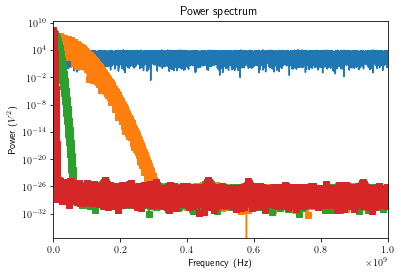

In [6]:
V_1 = FrequencyFilter(t,V, 25.0e6)
V_2 = FrequencyFilter(t,V, 5.0e6)
V_3 = FrequencyFilter(t,V, 1.0e6)

f, PWRspectrum = PowerSpectrum(t,V)
f_1, PWRspectrum_1 = PowerSpectrum(t,V_1)
f_2, PWRspectrum_2= PowerSpectrum(t,V_2)
f_3, PWRspectrum_3 = PowerSpectrum(t,V_3)

fig, ax = plt.subplots()
ax.plot(f,PWRspectrum)
ax.plot(f_1,PWRspectrum_1, '-s')
ax.plot(f_2,PWRspectrum_2, '-s')
ax.plot(f_3,PWRspectrum_3, '-s')
ax.set_title("Power spectrum")
ax.set_ylabel("Power ($V^2$)")
ax.set_xlabel("Frequency (Hz)")
ax.set_xlim(0,1e9)
ax.set_yscale('log')
plt.show()

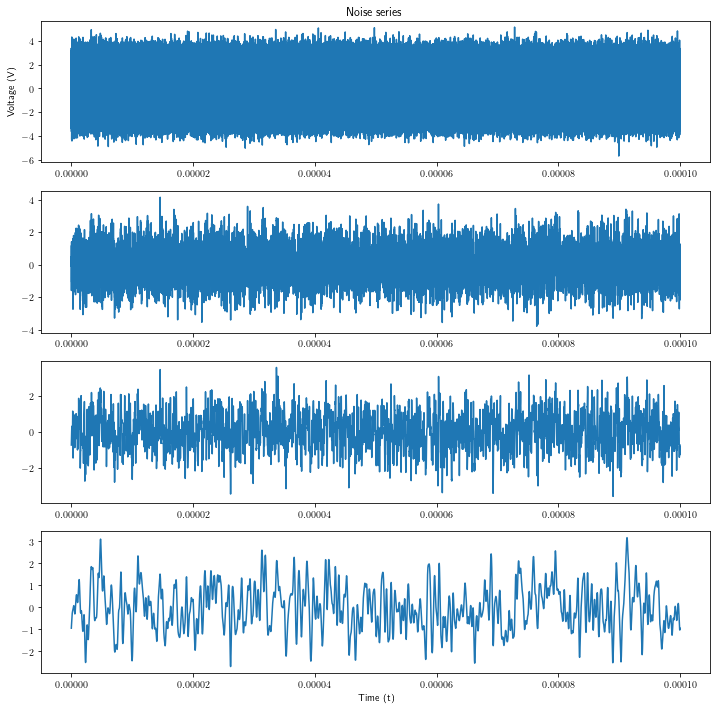

In [7]:
fig, ax = plt.subplots(4, figsize = (12,12))
ax[0].plot(t,V)
ax[1].plot(t,V_1)
ax[2].plot(t,V_2)
ax[3].plot(t,V_3)
ax[0].set_title("Noise series")
ax[0].set_ylabel("Voltage (V)")
ax[3].set_xlabel("Time (t)")
# ax[0].set_xlim(0,1000/f_0)
plt.show()

## Dithering the frequency of my laser with phase modulation

Alright, now how am I going to modulate the frequency of my laser using my noise source $N(t)$? 

Well, the easiest way I know is to just modulate the phase, like so

$E(t) = \cos(2 \pi f_0 t + B N(t))$

Consider a simple example below, where $N(t) = sin(2 \pi \Omega t)$

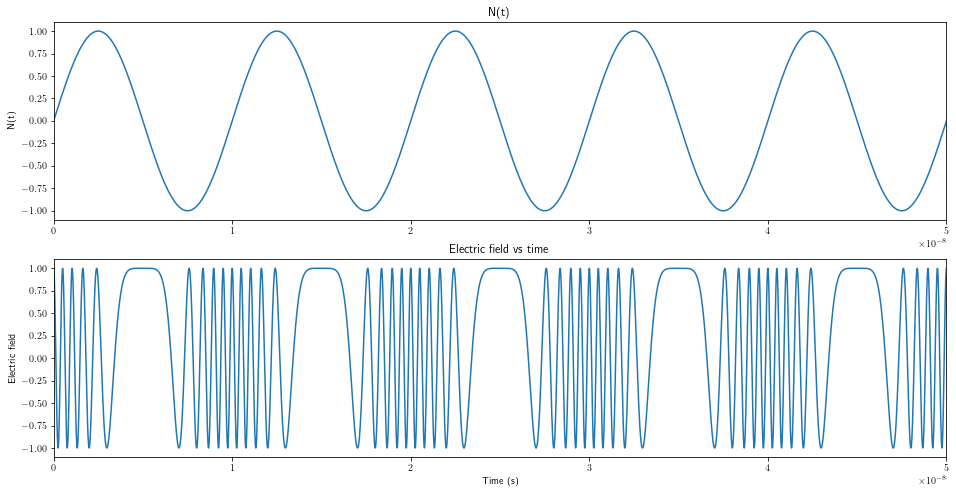

In [8]:
# A simple example of how frequency modulation works (accomplished by modulating the phase)
freq_mod = np.sin(2*np.pi*1e8*t)
E_fmod = np.cos(2*np.pi*f_0*t + 10*freq_mod)

fig, ax = plt.subplots(2, figsize = (16,8))
ax[0].plot(t,freq_mod, '-')
ax[0].set_title("N(t)")
ax[0].set_ylabel("N(t)")
ax[0].set_xlim(0,50/f_0)
ax[1].plot(t,E_fmod, '-')
ax[1].set_title("Electric field vs time")
ax[1].set_ylabel("Electric field")
ax[1].set_xlim(0,50/f_0)
ax[1].set_xlabel("Time (s)")
plt.show()

Great, now I'm going to replace my nice sinusoidal $N(t)$ with my actual slowly (or quickly) varying noise and look at how the frequency at which the electric field is oscillating changes. 

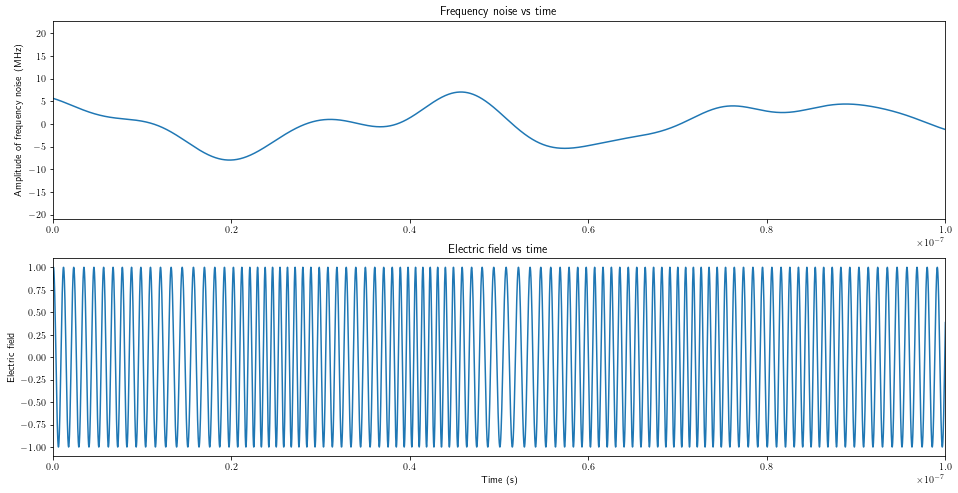

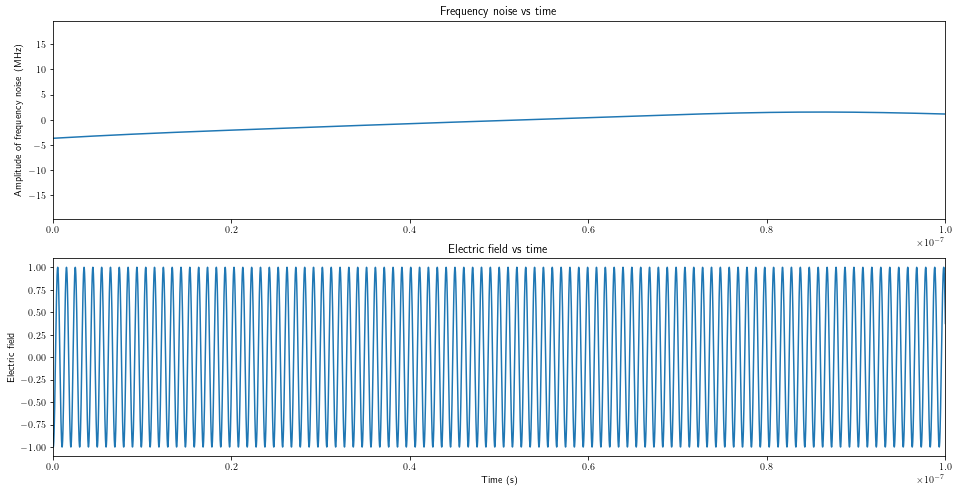

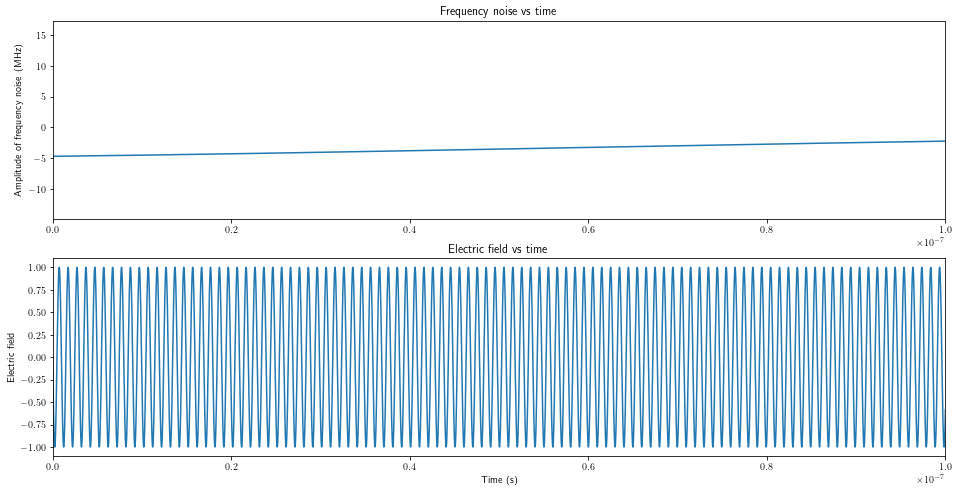

In [9]:
# First, we need to relate voltage to phase 
B = 5 # rad/V
E_fmod_1 = np.cos(2*np.pi*(f_0)*t + B*V_1)
E_fmod_2 = np.cos(2*np.pi*(f_0)*t + B*V_2)
E_fmod_3 = np.cos(2*np.pi*(f_0)*t + B*V_3)

stop = 100
fig, ax = plt.subplots(2, figsize = (16,8))
ax[0].plot(t,B*V_1, '-')
ax[0].set_title("Frequency noise vs time ")
ax[0].set_ylabel("Amplitude of frequency noise (MHz)")
ax[0].set_xlim(0,stop/f_0)
ax[1].plot(t,E_fmod_1, '-')
ax[1].set_title("Electric field vs time")
ax[1].set_ylabel("Electric field")
ax[1].set_xlim(0,stop/f_0)
ax[1].set_xlabel("Time (s)")

fig, ax = plt.subplots(2, figsize = (16,8))
ax[0].plot(t,B*V_2, '-')
ax[0].set_title("Frequency noise vs time ")
ax[0].set_ylabel("Amplitude of frequency noise (MHz)")
ax[0].set_xlim(0,stop/f_0)
ax[1].plot(t,E_fmod_2, '-')
ax[1].set_title("Electric field vs time")
ax[1].set_ylabel("Electric field")
ax[1].set_xlim(0,stop/f_0)
ax[1].set_xlabel("Time (s)")

fig, ax = plt.subplots(2, figsize = (16,8))
ax[0].plot(t,B*V_3, '-')
ax[0].set_title("Frequency noise vs time ")
ax[0].set_ylabel("Amplitude of frequency noise (MHz)")
ax[0].set_xlim(0,stop/f_0)
ax[1].plot(t,E_fmod_3, '-')
ax[1].set_title("Electric field vs time")
ax[1].set_ylabel("Electric field")
ax[1].set_xlim(0,stop/f_0)
ax[1].set_xlabel("Time (s)")

plt.show()

Ok, interesting, but now let's find the power spectra for each of these scenarios. 

## Calculating the resulting power spectra

In [10]:
# Now, let's find the power spectra of these differently modulated electric fields
f,PwrSpectrum =  PowerSpectrum(t,E)
f_1, PwrSpectrum_1 = PowerSpectrum(t,E_fmod_1)
f_2, PwrSpectrum_2 = PowerSpectrum(t,E_fmod_2)
f_3, PwrSpectrum_3 = PowerSpectrum(t,E_fmod_3)

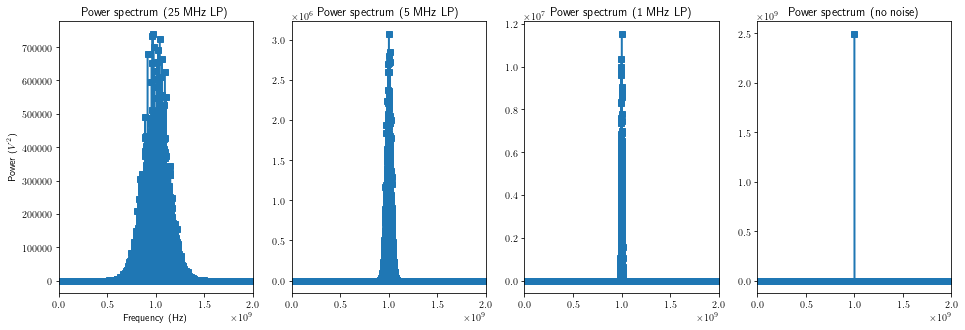

In [11]:
fig, ax = plt.subplots(1,4, figsize = (16,5))
ax[0].plot(f_1,PwrSpectrum_1, '-s')
ax[1].plot(f_2,PwrSpectrum_2, '-s')
ax[2].plot(f_3,PwrSpectrum_3, '-s')
ax[3].plot(f,PwrSpectrum, '-s')
ax[0].set_title("Power spectrum (25 MHz LP)")
ax[1].set_title("Power spectrum (5 MHz LP)")
ax[2].set_title("Power spectrum (1 MHz LP)")
ax[3].set_title("Power spectrum (no noise)")
ax[0].set_ylabel("Power ($V^2$)")
ax[0].set_xlabel("Frequency (Hz)")
ax[0].set_xlim(0,2*f_0)
ax[1].set_xlim(0,2*f_0)
ax[2].set_xlim(0,2*f_0)
ax[3].set_xlim(0,2*f_0)
plt.show()

You can definitely see that the effect of phase modulation is to broaden out the laser spectrum, and that higher frequency phase noise broadens out the laser more than low frequency phase noise. 

These are noisy signals, but I can downsample a bit and then fit to a Gaussian to get an estimate of the laser linewidth in each case. 

In [12]:
# I'd like to downsample this signal
downsample = 50
PwrSpectrum_1_down = sig.resample(PwrSpectrum_1, int(len(PwrSpectrum_1)/downsample))  
PwrSpectrum_2_down = sig.resample(PwrSpectrum_2, int(len(PwrSpectrum_2)/downsample))  
PwrSpectrum_3_down = sig.resample(PwrSpectrum_3, int(len(PwrSpectrum_3)/downsample))
f_1_down = sig.resample(f_1,int(len(f_1)/downsample))

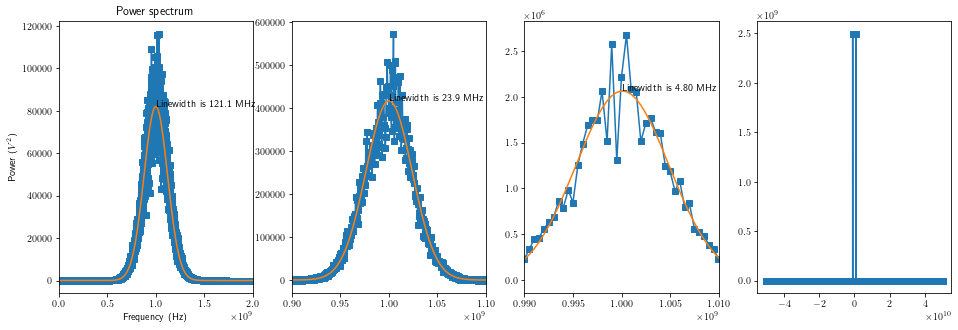

In [13]:
fig, ax = plt.subplots(1,4, figsize = (16,5))

def Gaussian(f,f_0,sigma, A):
    return A*np.exp(-(f-f_0)**2/2/sigma**2)

popt_1, pcov_1 = curve_fit(Gaussian, f_1_down, PwrSpectrum_1_down, bounds =([0.99e9, 0.00015e9, 1e4 ],[1.01e9, 1e9,10e9]))
popt_2, pcov_2 = curve_fit(Gaussian, f_1_down, PwrSpectrum_2_down, bounds =([0.99e9, 0.00015e9, 1e4 ],[1.01e9, 1e9,10e9]))
popt_3, pcov_3 = curve_fit(Gaussian, f_1_down, PwrSpectrum_3_down, bounds =([0.99e9, 0.00015e9, 1e4 ],[1.01e9, 1e9,10e9]))

ax[0].plot(f_1_down,PwrSpectrum_1_down, '-s')
ax[0].plot(f_1_down,Gaussian(f_1_down,*popt_1))
ax[0].text(1e9, popt_1[2], "Linewidth is %1.1f MHz" %(popt_1[1]/1e6))
ax[1].plot(f_1_down,PwrSpectrum_2_down, '-s')
ax[1].plot(f_1_down,Gaussian(f_1_down,*popt_2))
ax[1].text(1e9, popt_2[2], "Linewidth is %1.1f MHz" %(popt_2[1]/1e6))
ax[2].plot(f_1_down,PwrSpectrum_3_down, '-s')
ax[2].plot(f_1_down,Gaussian(f_1_down,*popt_3))
ax[2].text(1e9, popt_3[2], "Linewidth is %1.2f MHz" %(popt_3[1]/1e6))
ax[3].plot(f,PwrSpectrum, '-s')
ax[0].set_title("Power spectrum")
ax[0].set_ylabel("Power ($V^2$)")
ax[0].set_xlabel("Frequency (Hz)")
ax[0].set_xlim(0,2*f_0)
ax[1].set_xlim(f_0-0.1e9, f_0+0.1e9,)
ax[2].set_xlim(f_0-0.01e9, f_0+0.01e9,)
ax[0].set_xlim(0,2*f_0)
# ax.set_yscale('log')
plt.show()

## How does the width of the power spectrum depend on the phase noise? 

Having run this a few times for different values of B, what I am seeing is that the linewidth is proportional to the amplitude of the phase modulation (B) and also to the bandwidth ($f_c$). 

Below, I've plotted the linewidth for the 5 MHz bandwidth as a function of B. 

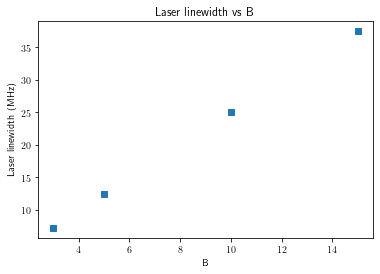

In [14]:
list_of_beta = np.array([5,10, 3, 15])
list_of_linewidth = np.array([12.4, 25, 7.2, 37.6])
plt.figure()
plt.plot(list_of_beta, list_of_linewidth, 's')
plt.title("Laser linewidth vs B")
plt.xlabel("B")
plt.ylabel("Laser linewidth (MHz)")
plt.show()

What I am finding is that I can broaden out a laser's lineshape by noisy phase modulation. The final bandwidth depends linearly on the bandwidth of the noise spectrum, as well as on the amplitude of the phase modulation. 

I would like to come up with a simple formula for linewidth as a function of noise amplitude and bandwidth.

It looks to me like the laser lineshape is simply a product of B and the cut off frequency used over 2. Let's check this. 

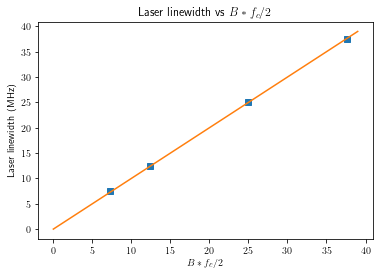

In [15]:
cut_off = 5 # MHz
predicted_linewidth = cut_off*list_of_beta/2  # MHz
plt.figure()
plt.plot(list_of_linewidth, predicted_linewidth, 's')
plt.plot(np.arange(0,40,1), np.arange(0,40,1))
plt.title("Laser linewidth vs $B*f_c/2$")
plt.ylabel("Laser linewidth (MHz)")
plt.xlabel("$B*f_c/2$")
plt.show()

Alright, so what I have found is that the laser's linewidth is equal to B multiplied by the highest frequency (the cut-off frequency) at which the phase is oscillating. 

## Comparing the resulting power spectrum to the distribution of instantaneous frequencies

How does the shape of my power spectrum compare to the distribution of instantaneous frequencies? 

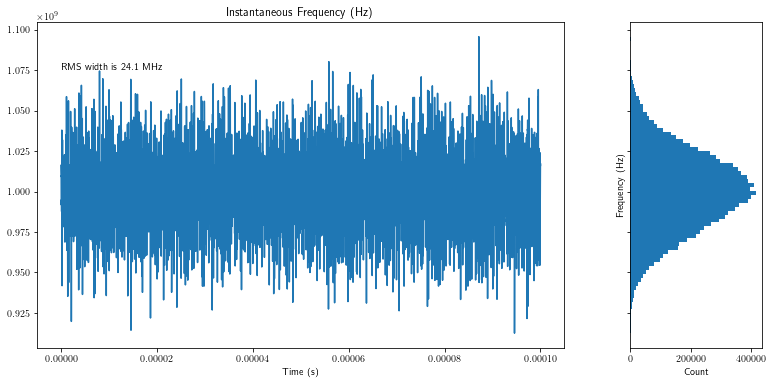

In [23]:
# Well, the phase is
Phase = 2*np.pi*f_0*t + B*V_2
Instant_freq = np.gradient(Phase, dt)/(2*np.pi)


fig, axes = plt.subplots(nrows=1,ncols=2, figsize=[13,6], sharey=True, gridspec_kw={'width_ratios': [4, 1]})
axes[0].plot(t,Instant_freq)
axes[0].set_xlabel("Time (s)")
axes[0].set_title("Instantaneous Frequency (Hz)")
axes[0].text(0,1.075e9,"RMS width is %1.1f MHz" %(np.std(Instant_freq/1e6)))
# axes[0].set_xlim(0,stop/f_0)
axes[1].hist(Instant_freq, bins=75, orientation='horizontal')
axes[1].set_xlabel("Count")
axes[1].set_ylabel("Frequency (Hz)")
plt.show()

Interestingly, what I have just shown is that, at least for the special case of random lowpassed phase noise that I am considering here, the distribution of instantaneous frequencies equals the distribution of Fourier frequencies. 

Note that this is in general not true. For example, consider the common situation of phase modulation at a single frequency:

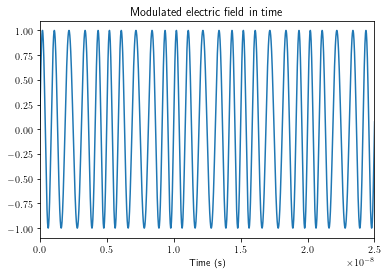

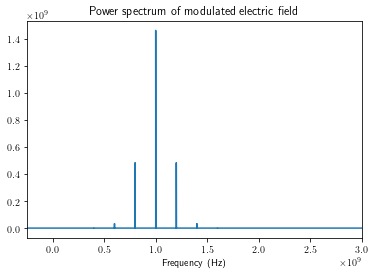

In [26]:
# Let's modulate an electric field with carrier frequency f_0 at frequency Omega and modulation depth B
Omega = 0.2e9 # Modulation frequency
B = 1 # Modulation depth
Phase = np.sin(2*np.pi*Omega*t) # Phase modulation

# Modulated electric field
E_modulated = np.sin(2*np.pi*f_0*t + B*Phase)

# Let's plot it in time
xlimit = t_max/4000
plt.figure()
plt.plot(t,E_modulated, label = "E(t)")
plt.xlim(0,xlimit)
plt.title("Modulated electric field in time")
plt.xlabel("Time (s)")
# plt.legend()

# Let's calculate the power spectrum
f, Spectrum_modulated = PowerSpectrum(t,E_modulated)

# Let's plot the power spectrum
plt.figure()
plt.plot(f,Spectrum_modulated)
plt.xlim(-0.25e9,3e9)
plt.title("Power spectrum of modulated electric field")
plt.xlabel("Frequency (Hz)")
plt.show()

Now, what is the instantaneous frequency doing in this case? 

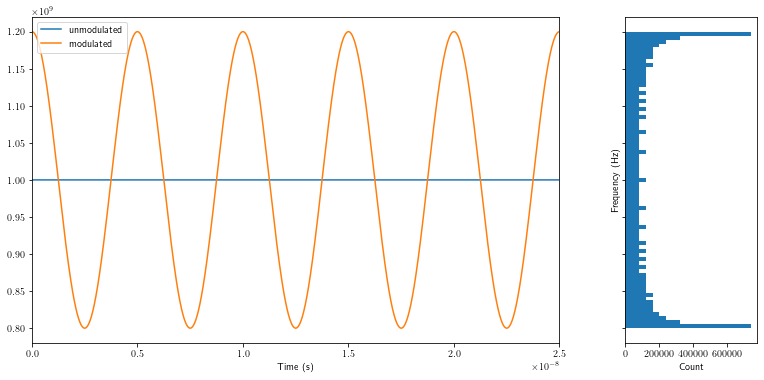

In [27]:
# Alright, but what is the instantaneous frequency doing? 
# Well it's just the time-derivative of the electric field
instant_freq_unmodulated = np.gradient(2*np.pi*f_0*t,dt)/(2*np.pi)
instant_freq_modulated = np.gradient(2*np.pi*f_0*t + B*Phase, dt)/(2*np.pi)

fig, axes = plt.subplots(nrows=1,ncols=2, figsize=[13,6], sharey=True, gridspec_kw={'width_ratios': [4, 1]})
axes[0].plot(t,instant_freq_unmodulated, label = "unmodulated")
axes[0].plot(t,instant_freq_modulated, label = "modulated")
axes[0].set_xlabel("Time (s)")
axes[0].legend(loc = "upper left")
axes[0].set_xlim(0,xlimit)
axes[1].hist(instant_freq_modulated, bins=75, orientation='horizontal')
axes[1].set_xlabel("Count")
axes[1].set_ylabel("Frequency (Hz)")
plt.show()

Clearly, the instantaneous frequency is not equal to the Fourier frequency, and the distribution of instantaneous frequencies (from the histogram) is not the same as the distribution of Fourier frequencies (from the power spectrum). 